In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, SimpleRNN, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [2]:
# ---- PARAMETERS ----
FS            = 50        # sampling freq (Hz)
WINDOW_SZ     = 50        # window size (samples ≈1s)
EPOCHS        = 100
BATCH_SIZE    = 64
PLOT_DURATION = 10        # seconds to plot

# Filepaths for each walking speed
DATA_FILES = {
    "fastest": "Project/imu_data_fastest_speed.csv",
    "medium":  "Project/imu_data_medium_speed.csv",
    "slowest": "Project/imu_data_slowest_speed.csv"
}

### Loading IMU Data

In [3]:
def load_imu_data(path):
    return pd.read_csv(path)

### Quaternion to Pitch Conversion

In [4]:
def quaternion_to_pitch(w, x, y, z):
    t2 = 2.0 * (w*y - x*z)
    t5 = w*w - x*x - y*y + z*z
    return np.degrees(np.arctan2(t2, t5))

### Visualize Data

In [5]:
def plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix):
    mask = times <= PLOT_DURATION
    mask2 = times2 <= PLOT_DURATION
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].plot(times[mask], df['pitch1_sm'][mask], label='Thigh Pitch (sm)')
    ax[0].plot(times[mask], df['pitch2_sm'][mask], label='Shin Pitch (sm)')
    for t in times[minima_idx]:
        if t <= PLOT_DURATION:
            ax[0].axvline(t, color='k', ls='--', alpha=0.6)
    ax[0].set_title(f"Pitch & Toe-offs (0-{PLOT_DURATION}s)")
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Pitch (°)')
    ax[0].legend()

    ax[1].plot(times[mask], df['omega1'][mask], label='Thigh ω (°/s)')
    ax[1].plot(times[mask], df['omega2'][mask], label='Shin ω (°/s)')
    ax[1].set_title(f"Angular Velocity (0-{PLOT_DURATION}s)")
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular velocity (°/s)')
    ax[1].legend()

    ax[2].plot(times2[mask2], df2['t_toeoff'][mask2])
    ax[2].set_title(f"Time-to-Toe-off vs Time (0-{PLOT_DURATION}s)")
    ax[2].set_xlabel('Time (s)')
    ax[2].set_ylabel('Seconds to Next Toe-off')

    ax[3].hist(df2['t_toeoff'], bins=50)
    ax[3].set_title(f"Time-to-Toe-off Distribution")
    ax[3].set_xlabel('Time to Toe-off (s)')
    ax[3].set_ylabel('Count')

    fig.suptitle(f"{title_prefix.upper()}")

    return fig

### Detect Toe-offs

In [6]:
pitch_plots = {}

def detect_and_plot_toeoffs(df, fs=FS, title_prefix=""):

    # compute raw & smoothed pitch
    df['pitch1'] = quaternion_to_pitch(df.QuatW,  df.QuatX,  df.QuatY,  df.QuatZ)
    df['pitch2'] = quaternion_to_pitch(df.QuatW2, df.QuatX2, df.QuatY2, df.QuatZ2)
    for c in ['pitch1','pitch2']:
        df[f'{c}_sm'] = (df[c]
                         .rolling(window=5, center=True)
                         .mean()
                         .fillna(method='bfill')
                         .fillna(method='ffill'))
    # compute angular velocities ω
    df['omega1'] = df['pitch1_sm'].diff().fillna(0) * fs
    df['omega2'] = df['pitch2_sm'].diff().fillna(0) * fs

    # time vector
    N     = len(df)
    times = np.arange(N) / fs

    # detect thigh-minima toe-offs AND only those below -100°
    minima_idx, _ = find_peaks(-df['pitch1_sm'].values, distance=int(0.3*fs))
    # filter to pitch1_sm[minima] < -100
    valid_minima = [i for i in minima_idx if df['pitch1_sm'].iloc[i] < -110]
    if len(valid_minima) < 2:
        raise RuntimeError(f"Too few thigh minima <-100° in {title_prefix}")
    minima_idx = np.array(valid_minima)

    # label time-to-toe-off
    next_toe = np.searchsorted(minima_idx, np.arange(N), side='right')
    valid    = next_toe < len(minima_idx)
    df2      = df.iloc[valid].reset_index(drop=True)
    times2   = times[valid]
    thigh_times = times[minima_idx]
    df2['t_toeoff'] = thigh_times[next_toe[valid]] - times2

    fig = plot_pitch_angle_and_toe_off(times, times2, df, df2, minima_idx, title_prefix)

    pitch_plots[title_prefix] = fig

    return df2

### Making Dataset

In [7]:
def make_dataset(df2):
    feature_cols = ['QuatW','QuatX','QuatY','QuatZ','AccX','AccY','AccZ','GyroX','GyroY','GyroZ',
                    'QuatW2','QuatX2','QuatY2','QuatZ2','AccX2','AccY2','AccZ2','GyroX2','GyroY2','GyroZ2']

    features = df2[feature_cols].values
    targets = df2['t_toeoff'].values
    X, y = [], []
    for i in range(WINDOW_SZ, len(features)):
        X.append(features[i-WINDOW_SZ:i])
        y.append(targets[i])

    X = np.stack(X)
    y = np.array(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(X).reshape(-1, X[0].shape[1])).reshape(-1, WINDOW_SZ, len(feature_cols))

    return X, y

### Machine Learning Approach

In [8]:
def RNN_make_model(input_shape, loss, metrics, optimizer):
    hidden_units_1 = 64
    hidden_units_2 = 32
    mlp_units = 16
    model = Sequential([
        SimpleRNN(hidden_units_1, return_sequences=True, input_shape=input_shape),
        SimpleRNN(hidden_units_2),
        Dense(mlp_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [9]:
def GRU_make_model(input_shape, loss, metrics, optimizer):
    hidden_units_1 = 64
    hidden_units_2 = 32
    mlp_units = 16
    model = Sequential([
        GRU(hidden_units_1, return_sequences=True, input_shape=input_shape),
        GRU(hidden_units_2),
        Dense(mlp_units, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.2356 - mae: 0.3636 - val_loss: 0.0750 - val_mae: 0.2060
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0649 - mae: 0.1925 - val_loss: 0.0639 - val_mae: 0.1841
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0588 - mae: 0.1762 - val_loss: 0.0551 - val_mae: 0.1756
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0495 - mae: 0.1590 - val_loss: 0.0509 - val_mae: 0.1667
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0460 - mae: 0.1525 - val_loss: 0.0443 - val_mae: 0.1496
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0408 - mae: 0.1388 - val_loss: 0.0416 - val_mae: 0.1409
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0364 - mae: 0.1303 - val_loss: 0.0390 - val_mae: 0.1356
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0349 - mae: 0.1255 - val_loss: 0.0372 - val_mae: 0.1283
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - l

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1743 - mae: 0.3167 - val_loss: 0.0641 - val_mae: 0.1842
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0544 - mae: 0.1693 - val_loss: 0.0484 - val_mae: 0.1538
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0424 - mae: 0.1439 - val_loss: 0.0417 - val_mae: 0.1393
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0348 - mae: 0.1248 - val_loss: 0.0380 - val_mae: 0.1288
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0294 - mae: 0.1125 - val_loss: 0.0392 - val_mae: 0.1285
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0284 - mae: 0.1094 - val_loss: 0.0370 - val_mae: 0.1260
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0274 - mae: 0.1058 - val_loss: 0.0321 - val_mae: 0.1164
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0246 - mae: 0.1017 - val_loss: 0.0296 - val_mae: 0.1106
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0236 -

<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
<ipython-input-6-256db8274293>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
<ipython-input-6-256db8274293>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill'))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.2367 - mae: 0.3539 - val_loss: 0.0747 - val_mae: 0.2002
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0693 - mae: 0.1826 - val_loss: 0.0606 - val_mae: 0.1653
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0492 - mae: 0.1485 - val_loss: 0.0504 - val_mae: 0.1521
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0458 - mae: 0.1417 - val_loss: 0.0502 - val_mae: 0.1494
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0444 - mae: 0.1376 - val_loss: 0.0472 - val_mae: 0.1375
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0426 - mae: 0.1319 - val_loss: 0.0411 - val_mae: 0.1332
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0334 - mae: 0.1178 - val_loss: 0.0404 - val_mae: 0.1249
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0330 - mae: 0.1164 - val_loss: 0.0372 - val_mae: 0.1212
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━

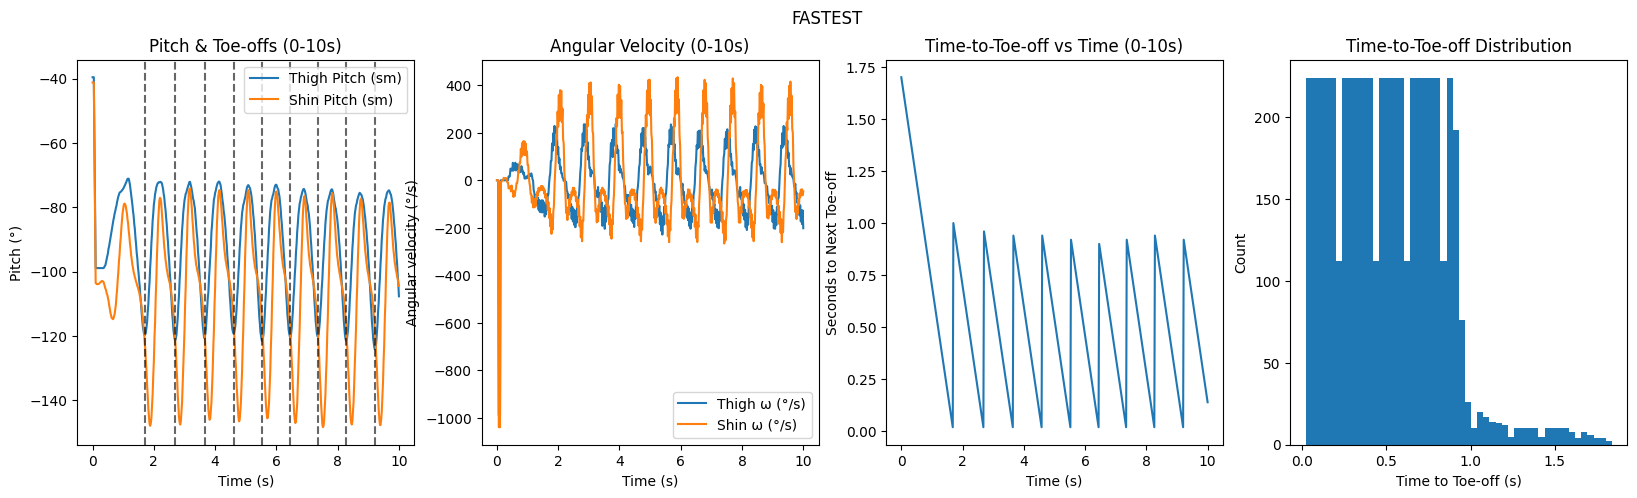

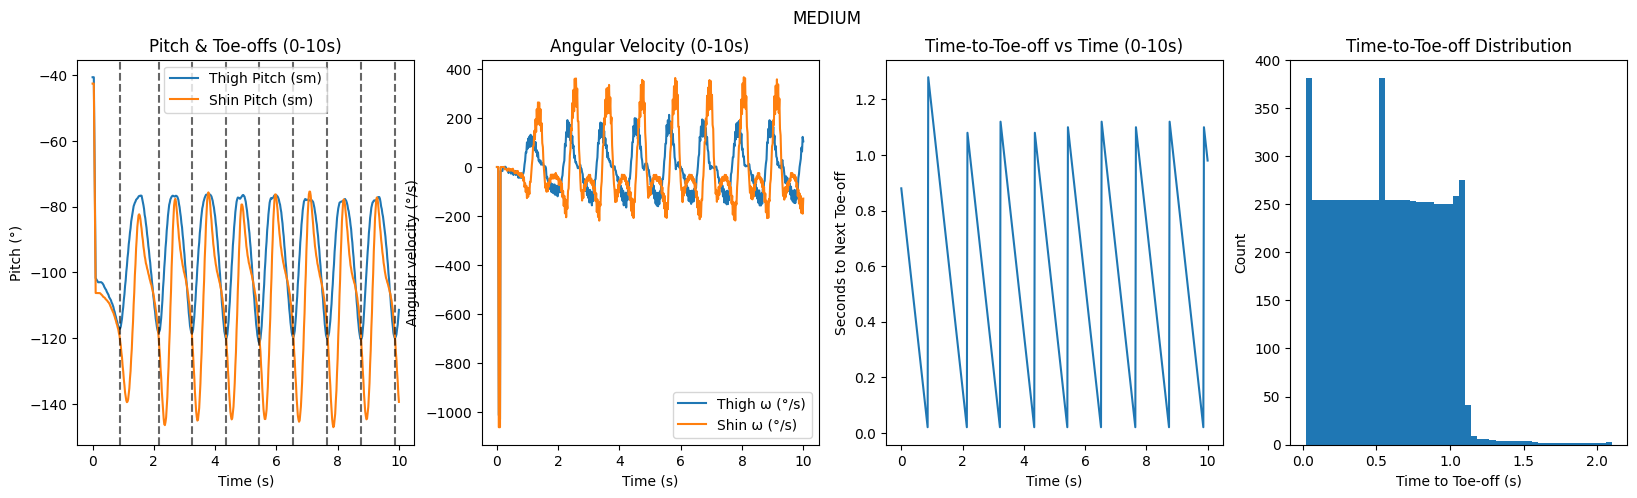

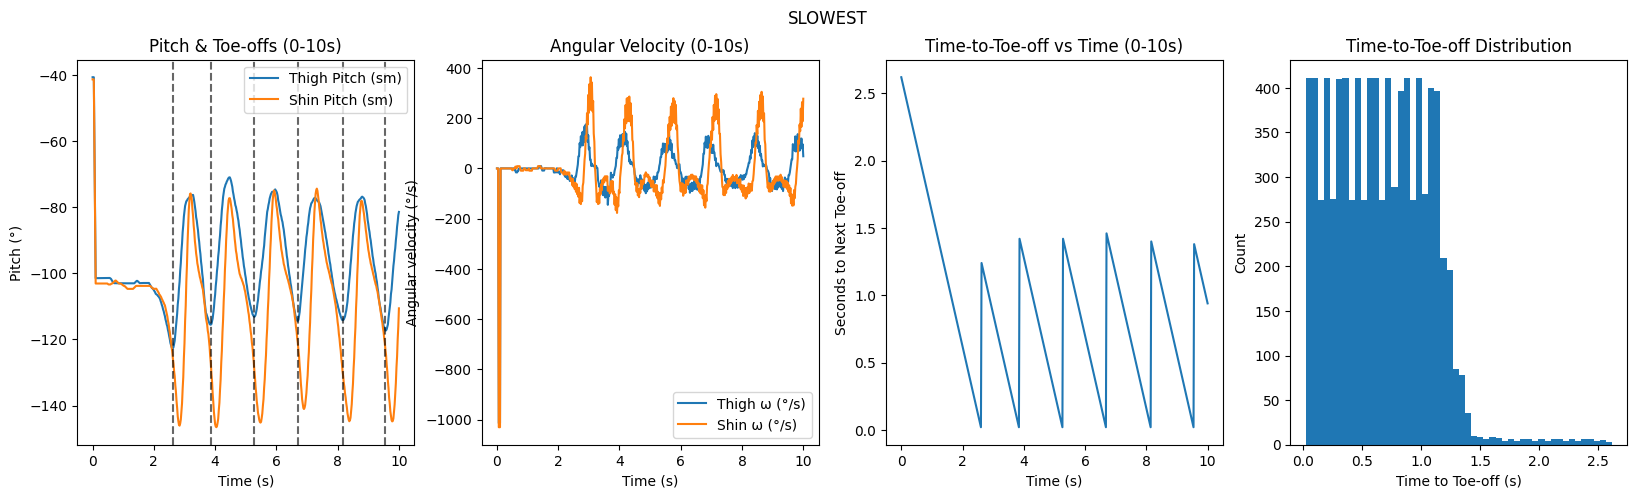

In [10]:
RNN_datasets   = {}
RNN_histories  = {}
RNN_metrics    = {}

GRU_datasets   = {}
GRU_histories  = {}
GRU_metrics    = {}

for name, path in DATA_FILES.items():
    df    = load_imu_data(path)
    df2   = detect_and_plot_toeoffs(df, title_prefix=name.capitalize())
    X, y  = make_dataset(df2)
    # idx   = np.random.permutation(len(X))
    # cut   = int(0.8 * len(X))
    # tr, te = idx[:cut], idx[cut:]
    # X_tr, y_tr = X[tr], y[tr]
    # X_te, y_te = X[te], y[te]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    input_shape = (WINDOW_SZ, X_train.shape[2])

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    RNN_model   = RNN_make_model(input_shape, loss, metrics, optimizer)
    history = RNN_model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss, mae = RNN_model.evaluate(X_test, y_test, verbose=0)
    print(f"{name.capitalize()} val MAE = {mae:.3f} for RNN")

    RNN_datasets[name] = (X_train, y_train, X_test, y_test, RNN_model)
    RNN_histories[name] = history
    RNN_metrics[name] = mae

    loss = 'mse'
    metrics = ['mae']
    optimizer = 'adam'

    GRU_model   = GRU_make_model(input_shape, loss, metrics, optimizer)
    history = GRU_model.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    loss, mae = GRU_model.evaluate(X_test, y_test, verbose=0)
    print(f"{name.capitalize()} val MAE = {mae:.3f} for GRU")

    GRU_datasets[name] = (X_train, y_train, X_test, y_test, GRU_model)
    GRU_histories[name] = history
    GRU_metrics[name] = mae

In [11]:
# Combined dataset
X_train_all = np.concatenate([RNN_datasets[n][0] for n in RNN_datasets], axis=0)
y_train_all = np.concatenate([RNN_datasets[n][1] for n in RNN_datasets], axis=0)
X_test_all = np.concatenate([RNN_datasets[n][2] for n in RNN_datasets], axis=0)
y_test_all = np.concatenate([RNN_datasets[n][3] for n in RNN_datasets], axis=0)

loss = 'mse'
metrics = ['mae']
optimizer = 'adam'

combined_model   = RNN_make_model(input_shape, loss, metrics, optimizer)
combined_history = combined_model.fit(X_train_all, y_train_all,
                                      validation_data=(X_test_all, y_test_all),
                                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
print(f"Combined val MAE = {mae_c:.3f} for RNN")

RNN_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
RNN_histories["combined"]  = combined_history
RNN_metrics["combined"]    = mae_c

combined_model   = GRU_make_model(input_shape, loss, metrics, optimizer)
combined_history = combined_model.fit(X_train_all, y_train_all,
                                      validation_data=(X_test_all, y_test_all),
                                      epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
loss_c, mae_c = combined_model.evaluate(X_test_all, y_test_all, verbose=0)
print(f"Combined val MAE = {mae_c:.3f} for GRU")

GRU_datasets["combined"]   = (X_train_all, y_train_all, X_test_all, y_test_all, combined_model)
GRU_histories["combined"]  = combined_history
GRU_metrics["combined"]    = mae_c

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - loss: 0.1743 - mae: 0.3050 - val_loss: 0.0660 - val_mae: 0.1860
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0617 - mae: 0.1786 - val_loss: 0.0531 - val_mae: 0.1607
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0497 - mae: 0.1543 - val_loss: 0.0465 - val_mae: 0.1477
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0449 - mae: 0.1446 - val_loss: 0.0414 - val_mae: 0.1335
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0412 - mae: 0.1346 - val_loss: 0.0401 - val_mae: 0.1317
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0394 - mae: 0.1297 - val_loss: 0.0384 - val_mae: 0.1250
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0355 - mae: 0.1215 - val_loss: 0.0338 - val_mae: 0.1192
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0334 - mae: 0.1178 - val_loss: 0.0344 - val_mae: 0.1210
Epoch 9/100
262/262 ━━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


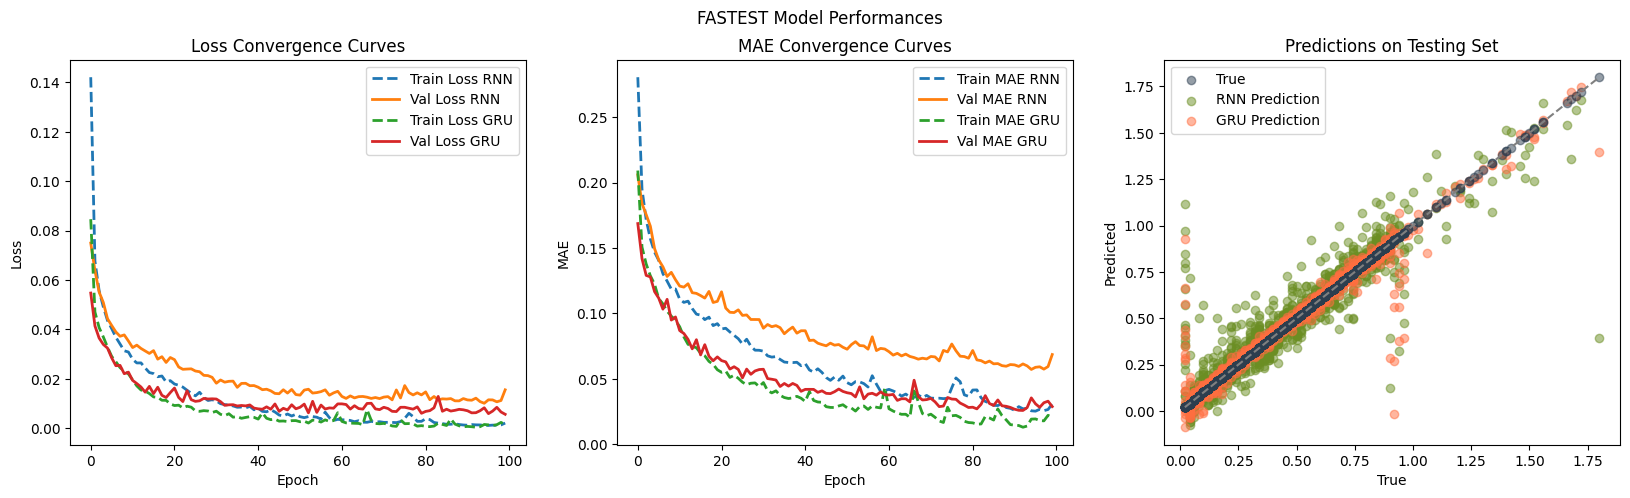

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


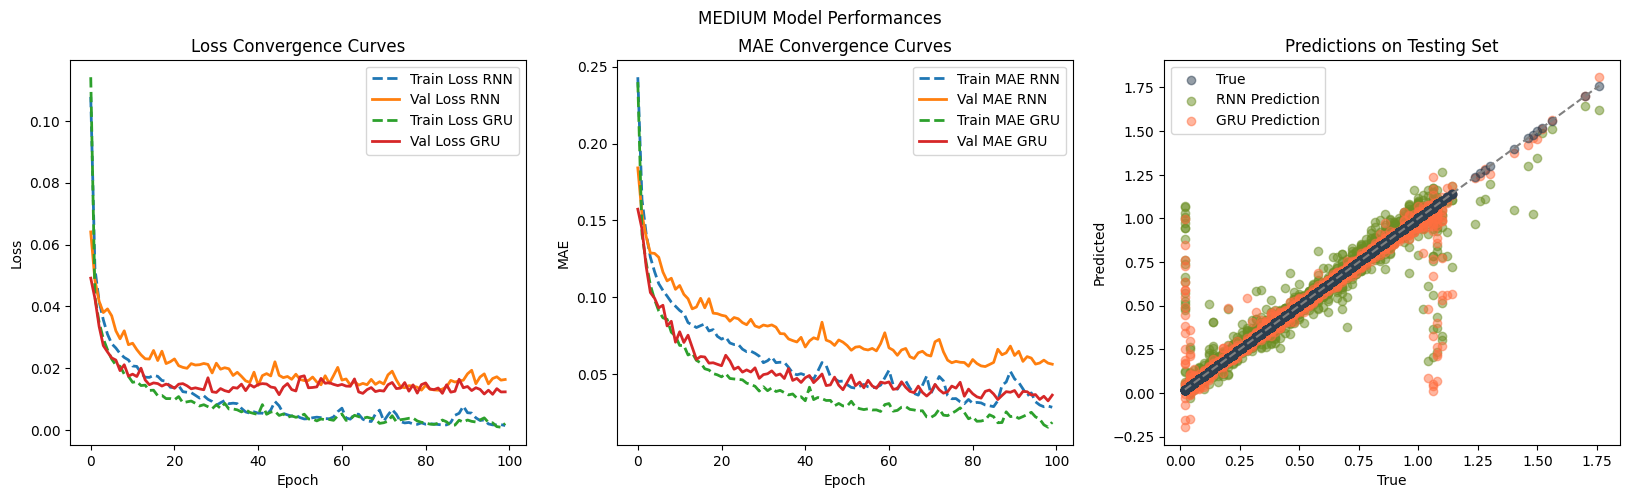

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


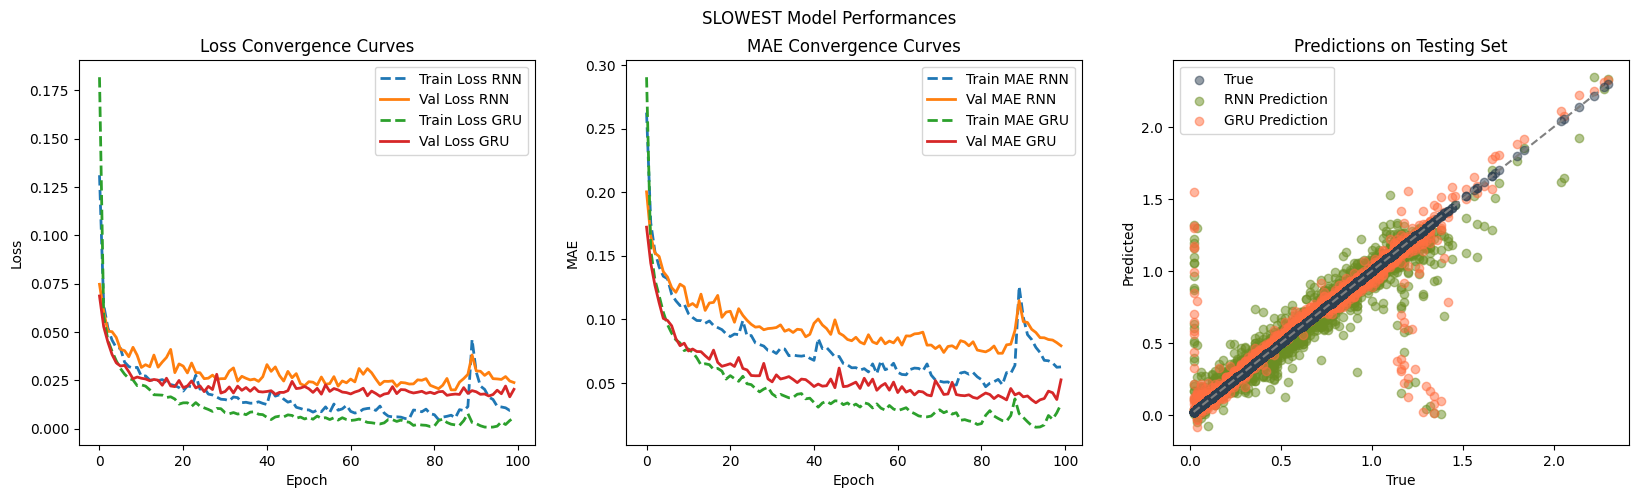

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


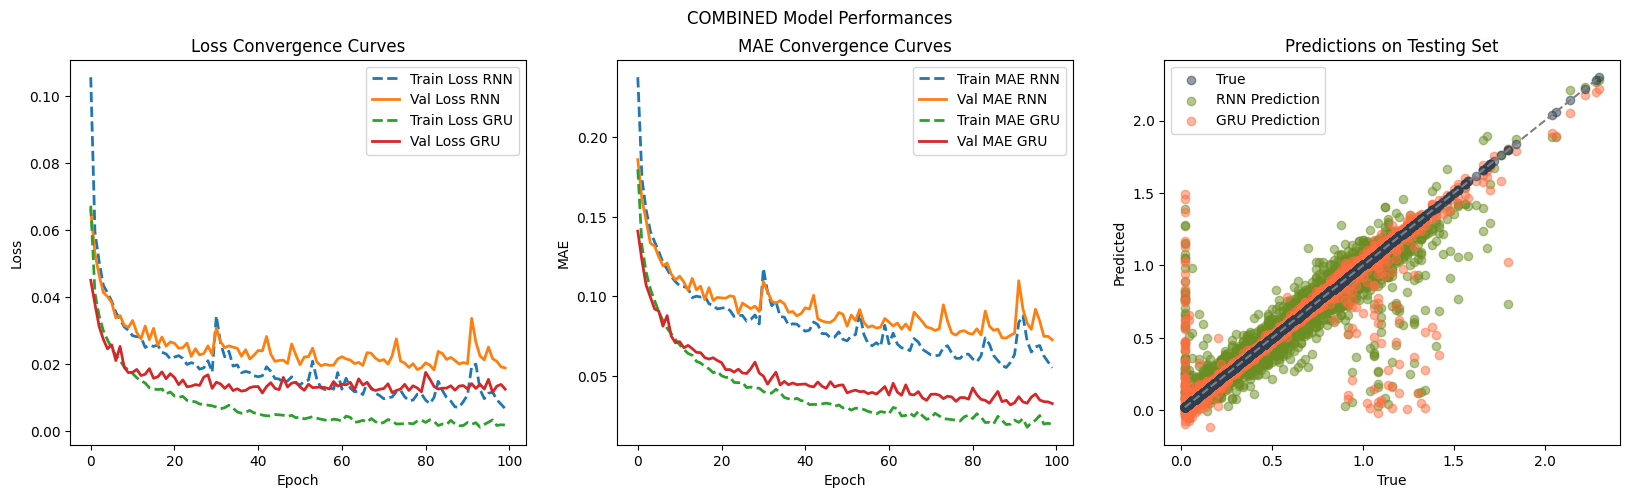

In [18]:
for name in list(RNN_histories.keys()):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"{name.upper()} Model Performances")

    X_test, y_test, model = RNN_datasets[name][2], RNN_datasets[name][3], RNN_datasets[name][4]
    history_rnn = RNN_histories[name]
    y_pred_rnn = model.predict(X_test).flatten()

    X_test, y_test, model = GRU_datasets[name][2], GRU_datasets[name][3], GRU_datasets[name][4]
    history_gru = GRU_histories[name]
    y_pred_gru = model.predict(X_test).flatten()

    ax[0].plot(history_rnn.history['loss'], '--', lw = 2, label='Train Loss RNN')
    ax[0].plot(history_rnn.history['val_loss'], lw = 2, label='Val Loss RNN')
    ax[0].plot(history_gru.history['loss'], '--', lw = 2, label='Train Loss GRU')
    ax[0].plot(history_gru.history['val_loss'], lw = 2, label='Val Loss GRU')
    ax[0].set_title("Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history_rnn.history['mae'], '--', lw = 2, label='Train MAE RNN')
    ax[1].plot(history_rnn.history['val_mae'], lw = 2, label='Val MAE RNN')
    ax[1].plot(history_gru.history['mae'], '--', lw = 2, label='Train MAE GRU')
    ax[1].plot(history_gru.history['val_mae'], lw = 2, label='Val MAE GRU')
    ax[1].set_title(f"MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()

    ax[2].scatter(y_test, y_test, alpha=0.5, color='#2C3E50', label='True', zorder=2)
    ax[2].scatter(y_test, y_pred_rnn, alpha=0.5, color='#6B8E23', label='RNN Prediction', zorder=0)
    ax[2].scatter(y_test, y_pred_gru, alpha=0.5, color='#FF6E40', label='GRU Prediction', zorder=1)
    ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
    ax[2].set_title(f"Predictions on Testing Set")
    ax[2].set_xlabel("True")
    ax[2].set_ylabel("Predicted")
    ax[2].legend()

    np.savez(f"RNN_{name}_history.npz", history=np.array([{'history': history_rnn.history, 'pred': (y_test, y_pred_rnn)}]))
    np.savez(f"GRU_{name}_history.npz", history=np.array([{'history': history_gru.history, 'pred': (y_test, y_pred_gru)}]))

    plt.show()

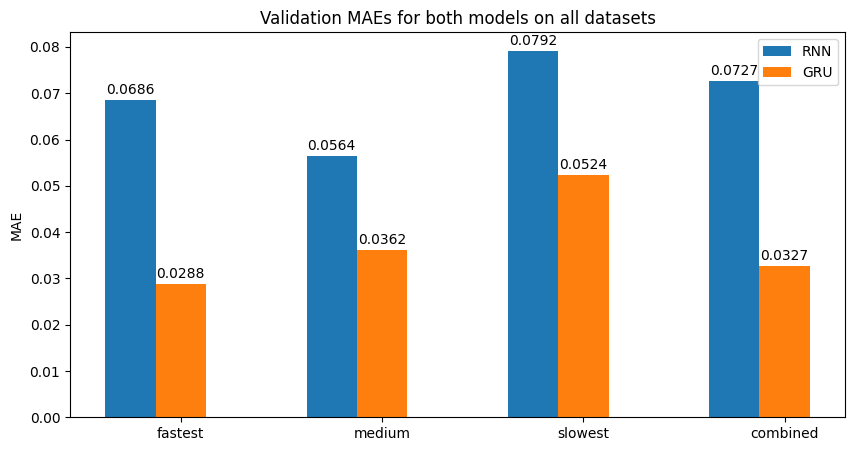

In [19]:
keys = list(RNN_metrics.keys())
x_axis = np.arange(len(keys))

rnn_vals = [RNN_metrics[k] for k in keys]
gru_vals = [GRU_metrics[k] for k in keys]

y_axis = {'RNN': rnn_vals, 'GRU': gru_vals}

bar_width = 0.25
multiplier = 0

plt.figure(figsize=(10, 5))
ax = plt.axes()

for algo, mae in y_axis.items():
    offset = bar_width * multiplier
    rects = ax.bar(x_axis + offset, np.round(mae, 4), bar_width, label=algo)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_ylabel('MAE')
ax.set_title('Validation MAEs for both models on all datasets')
ax.set_xticks(x_axis + bar_width, keys)
ax.legend(loc='upper right')

plt.show()

In [20]:
for name in list(RNN_datasets.keys()):
  fn = f"RNN_{name}.keras"
  model = RNN_datasets[name][-1]
  model.save(fn)
  print(f"Saved {name} to {fn}")

  fn = f"GRU_{name}.keras"
  model = GRU_datasets[name][-1]
  model.save(fn)
  print(f"Saved {name} to {fn}")

Saved fastest to RNN_fastest.keras
Saved fastest to GRU_fastest.keras
Saved medium to RNN_medium.keras
Saved medium to GRU_medium.keras
Saved slowest to RNN_slowest.keras
Saved slowest to GRU_slowest.keras
Saved combined to RNN_combined.keras
Saved combined to GRU_combined.keras


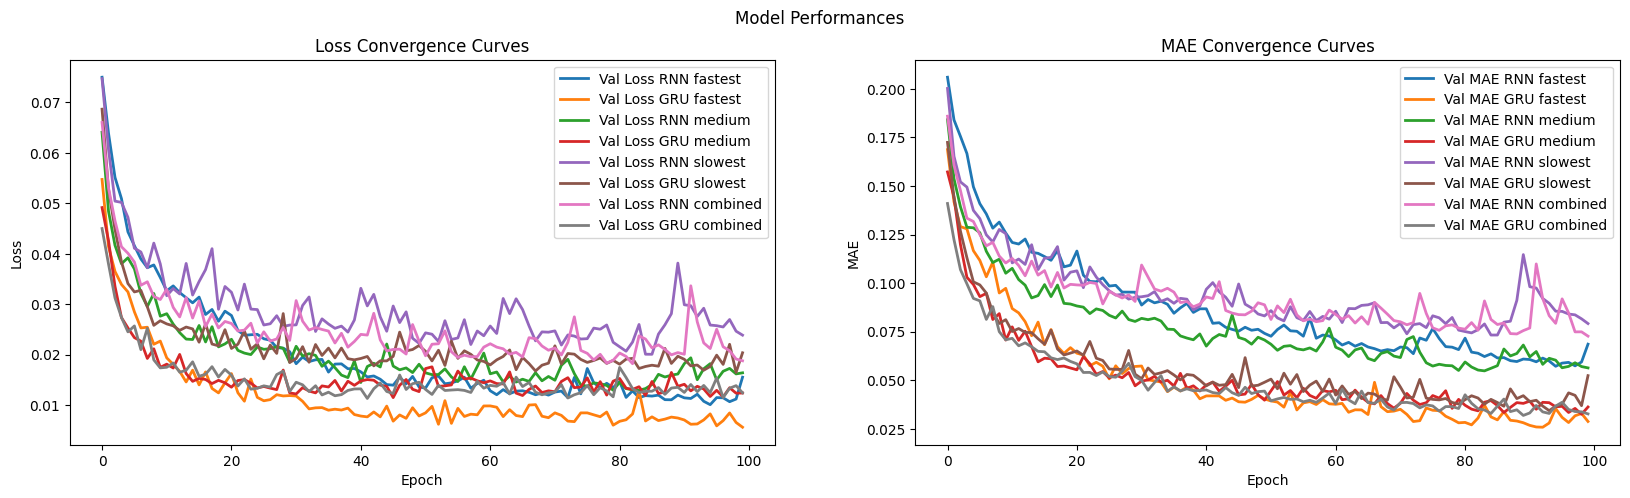

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f"Model Performances")

for name in list(RNN_histories.keys()):
    X_test, y_test, model = RNN_datasets[name][2], RNN_datasets[name][3], RNN_datasets[name][4]
    history_rnn = RNN_histories[name]
    # y_pred_rnn = model.predict(X_test).flatten()

    X_test, y_test, model = GRU_datasets[name][2], GRU_datasets[name][3], GRU_datasets[name][4]
    history_gru = GRU_histories[name]
    # y_pred_gru = model.predict(X_test).flatten()

    # ax[0].plot(history_rnn.history['loss'], '--', lw = 2, label=f'Train Loss RNN {name}')
    ax[0].plot(history_rnn.history['val_loss'], lw = 2, label=f'Val Loss RNN {name}')
    # ax[0].plot(history_gru.history['loss'], '--', lw = 2, label=f'Train Loss GRU {name}')
    ax[0].plot(history_gru.history['val_loss'], lw = 2, label=f'Val Loss GRU {name}')
    ax[0].set_title("Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # ax[1].plot(history_rnn.history['mae'], '--', lw = 2, label=f'Train MAE RNN {name}')
    ax[1].plot(history_rnn.history['val_mae'], lw = 2, label=f'Val MAE RNN {name}')
    # ax[1].plot(history_gru.history['mae'], '--', lw = 2, label=f'Train MAE GRU {name}')
    ax[1].plot(history_gru.history['val_mae'], lw = 2, label=f'Val MAE GRU {name}')
    ax[1].set_title(f"MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()

    # ax[2].scatter(y_test, y_test, alpha=0.5, color='#0072B2', label='True', zorder=2)
    # ax[2].scatter(y_test, y_pred_rnn, alpha=0.5, color='#E69F00', label='RNN Prediction', zorder=0)
    # ax[2].scatter(y_test, y_pred_gru, alpha=0.5, color='#009E73', label='GRU Prediction', zorder=1)
    # ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    # ax[2].set_title(f"Predictions on Testing Set")
    # ax[2].set_xlabel("True")
    # ax[2].set_ylabel("Predicted")
    # ax[2].legend()

plt.show()

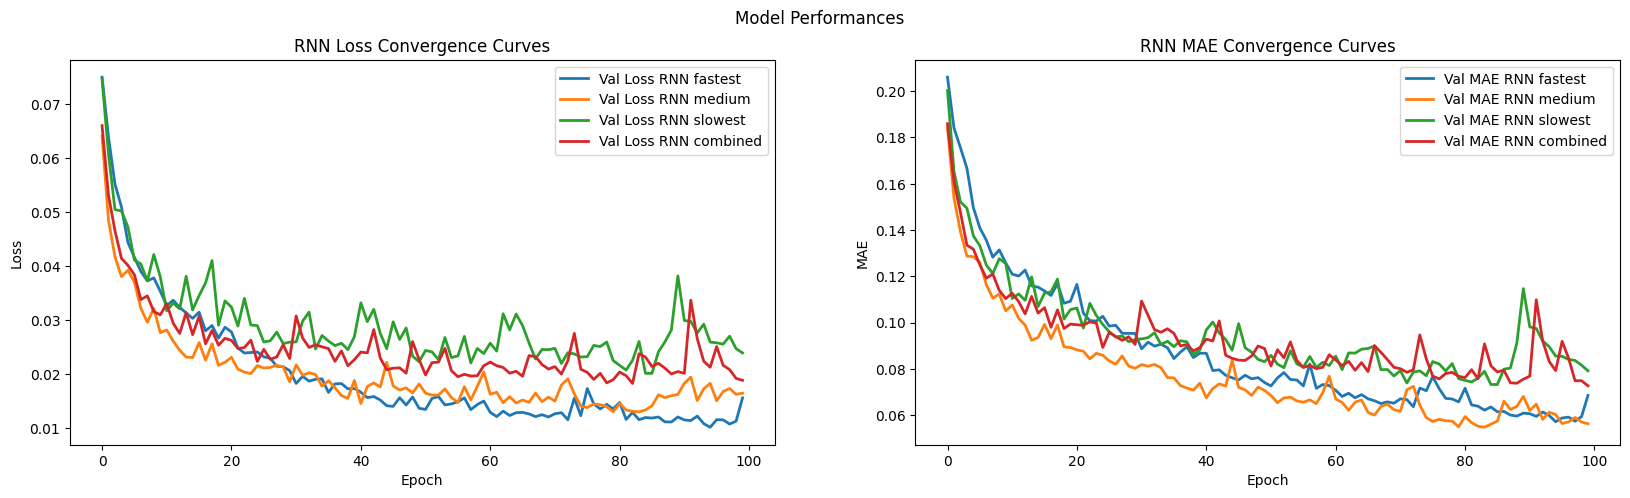

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f"Model Performances")

for name in list(RNN_histories.keys()):
    X_test, y_test, model = RNN_datasets[name][2], RNN_datasets[name][3], RNN_datasets[name][4]
    history_rnn = RNN_histories[name]
    # y_pred_rnn = model.predict(X_test).flatten()

    # ax[0].plot(history_rnn.history['loss'], '--', lw = 2, label=f'Train Loss RNN {name}')
    ax[0].plot(history_rnn.history['val_loss'], lw = 2, label=f'Val Loss RNN {name}')
    ax[0].set_title("RNN Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    # ax[1].plot(history_rnn.history['mae'], '--', lw = 2, label=f'Train MAE RNN {name}')
    ax[1].plot(history_rnn.history['val_mae'], lw = 2, label=f'Val MAE RNN {name}')
    ax[1].set_title(f"RNN MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()



plt.show()

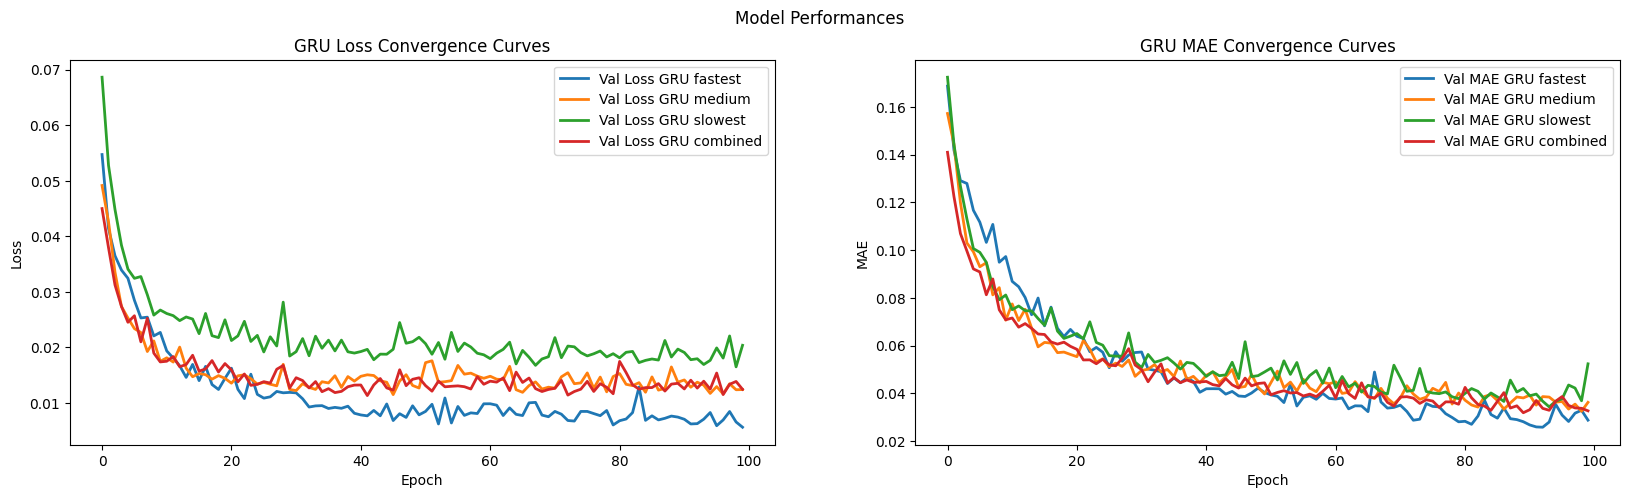

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f"Model Performances")

for name in list(RNN_histories.keys()):
    X_test, y_test, model = GRU_datasets[name][2], GRU_datasets[name][3], GRU_datasets[name][4]
    history_gru = GRU_histories[name]
    # y_pred_gru = model.predict(X_test).flatten()

    # ax[0].plot(history_gru.history['loss'], '--', lw = 2, label=f'Train Loss GRU {name}')
    ax[0].plot(history_gru.history['val_loss'], lw = 2, label=f'Val Loss GRU {name}')
    ax[0].set_title("GRU Loss Convergence Curves")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history_gru.history['val_mae'], lw = 2, label=f'Val MAE GRU {name}')
    ax[1].set_title(f"GRU MAE Convergence Curves")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("MAE")
    ax[1].legend()



plt.show()